In [5]:
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt 
from scipy.stats import norm, ttest_ind
import hashlib
%matplotlib inline

In [6]:
# Это мы в Clickhouse ходить будем
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [7]:
q = """
select views, count() as users
from (select  
    user_id,
    sum(action = 'view') as views
from simulator_20240620.feed_actions 
where toDate(time) between '2024-05-31' and '2024-06-06'
group by user_id
)
group by views
order by views
"""
#Это у нас запрос который показыывет кол-просмотров на пользвателя 
#Потом количество пользвателя на просмотр 
views_distribution = ph.read_clickhouse(q, connection=connection)

In [8]:
views_distribution.head()

,views,users
0,1,11
1,2,9
2,3,3
3,4,4
4,5,22


In [9]:
#общее количество пользователей 
views_distribution.users.sum()

49814

In [11]:
# p содержит вероятности (доли), показывающие, 
#какая часть от общего количества пользователей приходится на каждый просмотр.
#вероятность пользователей в каждой категории относительно общего количества пользователей.
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()

In [12]:
views_distribution.sort_values(by = 'p', ascending = False)

,views,users,p
13,14,637,0.012788
15,16,616,0.012366
14,15,606,0.012165
32,33,602,0.012085
33,34,597,0.011985
...,...,...,...
271,273,1,0.000020
279,282,1,0.000020
273,275,1,0.000020
277,280,1,0.000020


<AxesSubplot:xlabel='p', ylabel='Count'>

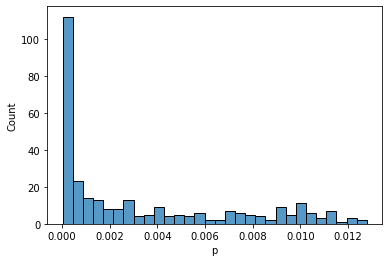

In [15]:
#график распределение вероятность пользвателя от общего колчичество 
sns.histplot(views_distribution.p, bins=30)

In [16]:
# создает дискретное распределение вероятностей
# Создает объект дискретного распределения, где значения и 
#их вероятности задаются массивами views_distribution['views'] и views_distribution['p'], соответственно.
views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views_distribution['views'], 
                                        views_distribution['p']))

In [17]:
views_distr.mean()

67.11753723852732

In [18]:
views_distr.median()

57.0

<AxesSubplot:ylabel='Count'>

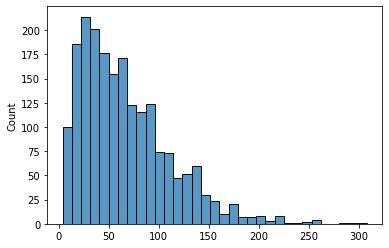

In [19]:
sns.histplot(views_distr.rvs(size=2000))

Достанем распределение CTR'ов за неделю

In [77]:
q = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator_20240620.feed_actions 
where dt between '2024-05-31' and '2024-06-06'
    and exp_group in (0,1,2,3,4)
group by dt, exp_group, user_id
)
group by ctr
"""


ctr_distribution = ph.read_clickhouse(q, connection=connection)

In [78]:
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()

In [79]:
ctr_distribution.sort_values(by = 'p', ascending = False)

,ctr,users,p
21,0.20,4977,0.051662
57,0.25,4298,0.044614
39,0.16,4111,0.042673
6,0.18,4015,0.041676
83,0.21,3799,0.039434
...,...,...,...
69,0.74,1,0.000010
9,0.91,1,0.000010
58,0.95,1,0.000010
47,0.87,1,0.000010


In [80]:
probabilities = ctr_distribution['p']
values = ctr_distribution['ctr']

In [81]:
# вместо значений использую индексы 
distrib = stats.rv_discrete(values=(range(len(probabilities)), probabilities))

In [82]:
# здесь используют значения 
# создает дискретное распределения на основе заданных значений 
# значениями являются просмотры и распределния просмотров на пользователя 
views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views_distribution['views'], 
                                        views_distribution['p']))

In [83]:
# функцию get_ctrs, которая генерирует двумерный массив значений 
# на основе дискретного распределения
def get_ctrs(x, y, distrib, values):
    idx = distrib.rvs(size=x*y) #Генерирует одномерный массив случайных индексов длиной x*y
    result = values[idx] #Извлекает значения из массива values на основе сгенерированных индексов idx
    return np.array(result).reshape(x,y) #Преобразует одномерный массив result в двумерный массив формы (x, y) и возвращает его

In [84]:
#Функция вернет двумерный массив размером 2000x2000,
# заполненный значениями CTR,
# выбранными на основе их вероятностей в распределении distrib.
get_ctrs(2000, 2000, distrib, values)

array([[0.24, 0.14, 0.27, ..., 0.18, 0.25, 0.43],
       [0.12, 0.14, 0.3 , ..., 0.17, 0.22, 0.41],
       [0.16, 0.15, 0.23, ..., 0.1 , 0.25, 0.21],
       ...,
       [0.12, 0.11, 0.28, ..., 0.33, 0.17, 0.28],
       [0.12, 0.32, 0.17, ..., 0.21, 0.33, 0.23],
       [0.32, 0.26, 0.12, ..., 0.16, 0.13, 0.2 ]])

# Синтетический А-А тест

In [54]:
q = """
select 
   stddevPop(ctr) as ctr_std
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator_20240620.feed_actions 
where dt between '2024-05-31' and '2024-06-06'
    and exp_group in (0,1,2,3,4)
group by dt, exp_group, user_id
)

"""

std = ph.read_clickhouse(q, connection=connection).values[0][0]

In [58]:
std = 0.0960210145931454

In [56]:
def compute_sample_size_abs(epsilon, std1, std2, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (std1 ** 2 + std2 ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

In [59]:
compute_sample_size_abs(0.01, std, std)

1448

In [85]:
group_A_views = views_distr.rvs(size = (2000, 2000)).astype("int32")
group_B_views = views_distr.rvs(size = (2000, 2000)).astype("int32")
group_A_ctr = get_ctrs(2000, 2000, distrib, values)*1.05
group_B_ctr = get_ctrs(2000,2000, distrib, values)

In [62]:
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)

ValueError: Domain error in arguments.

In [86]:
print("Минимальное значение в group_A_views:", group_A_views.min())
print("Максимальное значение в group_A_views:", group_A_views.max())
print("Минимальное значение в group_A_ctr:", group_A_ctr.min())
print("Максимальное значение в group_A_ctr:", group_A_ctr.max())

Минимальное значение в group_A_views: 1
Максимальное значение в group_A_views: 359
Минимальное значение в group_A_ctr: 0.0
Максимальное значение в group_A_ctr: inf


In [87]:
group_A_ctr[group_A_ctr > 1]

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf])

In [71]:
print("Тип данных group_A_views:", group_A_views.dtype)
print("Тип данных group_A_ctr:", group_A_ctr.dtype)

Тип данных group_A_views: int32
Тип данных group_A_ctr: float64


In [68]:
def t_test(a, b):
    """
    Считает p-value для t-теста с двусторонней альтернативой 
    :param a: np.array вида (n_experiments, n_users), значения метрик в контрольных группах
    :param b: np.array вида (n_experiments, n_users), значения метрик в тестовых группах
    :return: np.array вида (n_experiments), посчитанные p-value t-теста для всего списка экспериментов
    """
    result = list(map(lambda x: stats.ttest_ind(
        x[0], x[1], equal_var=False).pvalue, zip(a, b)))
    return np.array(result)

In [ ]:
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

In [ ]:
q = """
select 
   stddevPop(ctr) as ctr_std
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator_20240620.feed_actions 
where dt between '2024-05-31' and '2024-06-06'
    and exp_group in (0,1,2,3,4)
group by dt, exp_group, user_id
)

"""

In [ ]:
q = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator_20240620.feed_actions 
where dt between '2024-05-31' and '2024-06-06'
    and exp_group in (0,1,2,3,4)
group by dt, exp_group, user_id
)
group by ctr
"""

In [ ]:
q = """
select views, count() as users
from (select  
    user_id,
    sum(action = 'view') as views
from simulator_20240620.feed_actions 
where toDate(time) between '2024-05-31' and '2024-06-06'
group by user_id
)
group by views
order by views
"""